In [1]:
# !pip install matplotlib

In [2]:
# !pip install graphviz

In [63]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import random

In [4]:
def f(x):
    return 4*x**2 - 2*x + 1

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
print(xs)
print(ys)

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]
[111.   100.75  91.    81.75  73.    64.75  57.    49.75  43.    36.75
  31.    25.75  21.    16.75  13.     9.75   7.     4.75   3.     1.75
   1.     0.75   1.     1.75   3.     4.75   7.     9.75  13.    16.75
  21.    25.75  31.    36.75  43.    49.75  57.    64.75  73.    81.75]


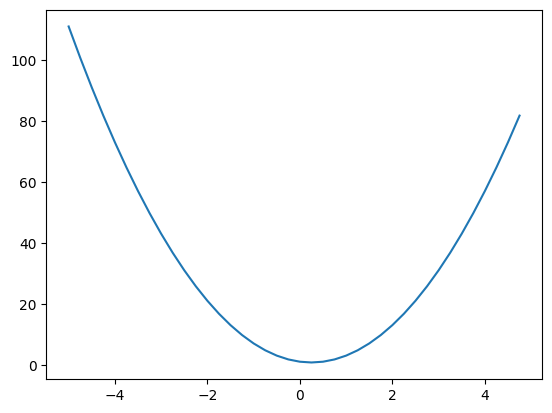

In [6]:
plt.plot(xs, ys)

Python variable naming conventions: https://www.datacamp.com/tutorial/role-underscore-python

### Scalar class Value

In [104]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        """
        data is the value of expression.
        _children defines what Values produced this Value.
        _op is the operator used.
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
        
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # if self*other is not possible, then check other*self
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "power functionality only supported for int/float"
        out = Value(self.data**other, (self, ), label = f"**{other}")
        
        def _backward():
            self.grad += other*(self.data**(other-1))*out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), label = 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def topo_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topo_sort(child)
                topo.append(v)
        
        topo_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(11.0, label = 'a')
b = Value(1.0, label = 'b')
c = Value(2.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'
L

Value(data = -26.0)

In [50]:
xx = Value(2.0)
yy = Value(3.0)
xx -yy

Value(data = -1.0)

### Function to draw DAG for neural net

In [8]:
def trace(root):
    """
    build a set of all nodes and edges in a graph
    """
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = "svg", graph_attr = {'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = "record")
        if n._op:
            # if this value is result of some operation, create a node for op
            dot.node(name = uid + n._op, label = n._op)
            #  and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

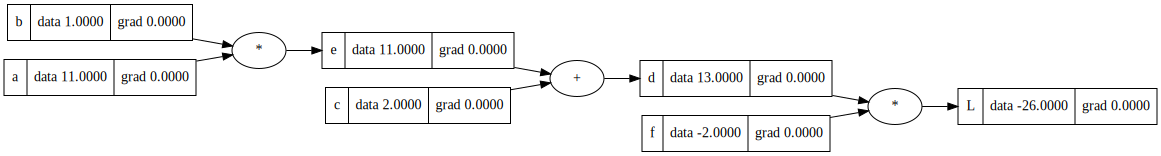

In [9]:
draw_dot(L)

### tanh function

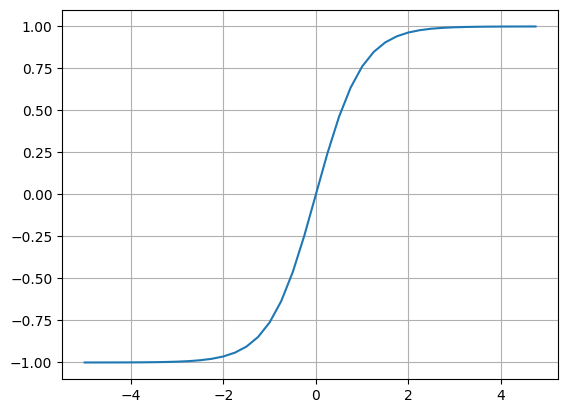

In [10]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25)))
plt.grid();

### Example

In [11]:
# input x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of neuron
b = Value(6.8813735870195432, label = 'b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

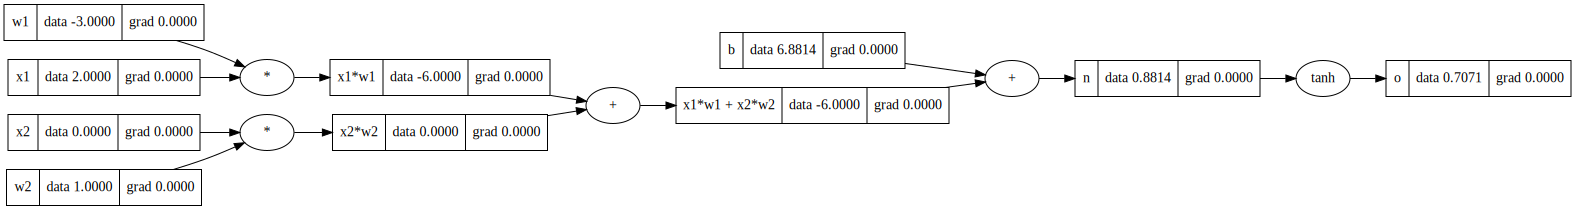

In [12]:
draw_dot(o)

### Manual backpropagation

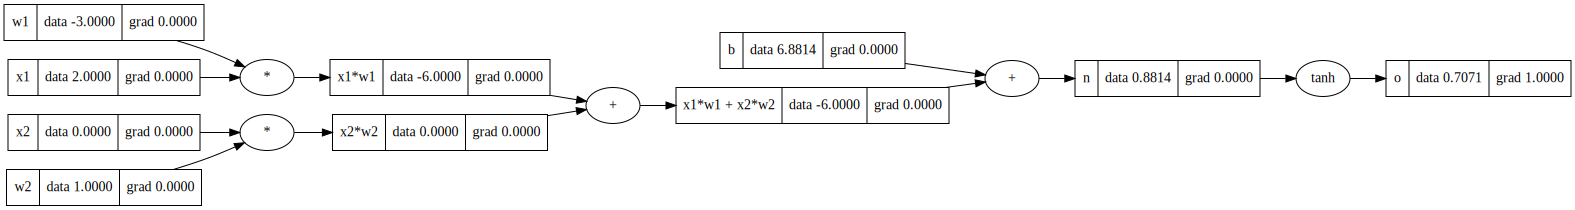

In [13]:
o.grad = 1
draw_dot(o)

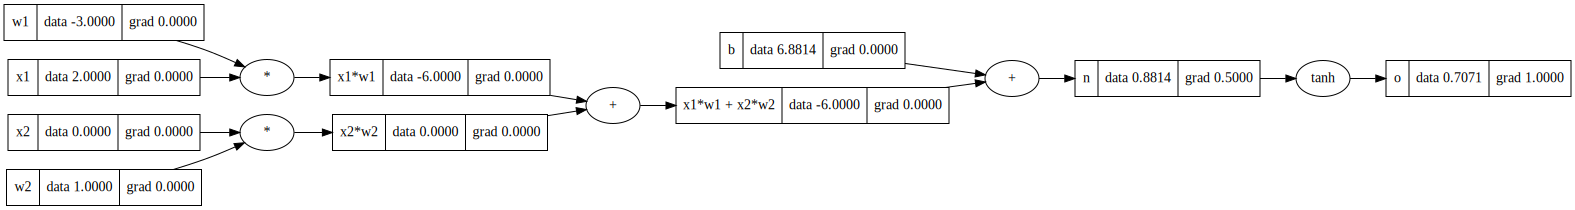

In [14]:
o._backward()
draw_dot(o)

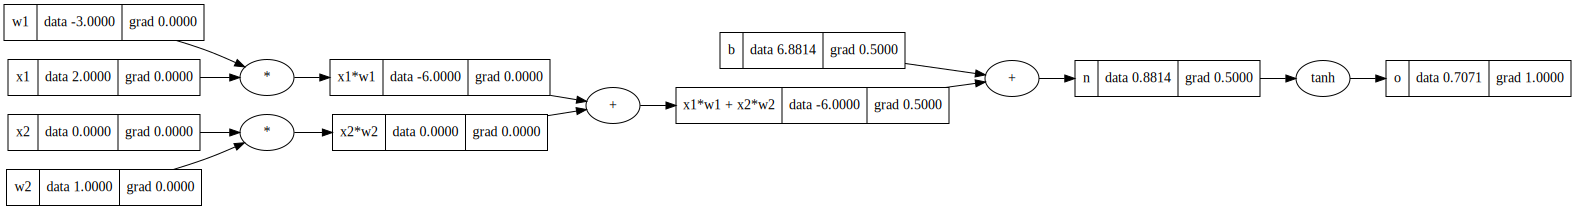

In [15]:
n._backward()
draw_dot(o)

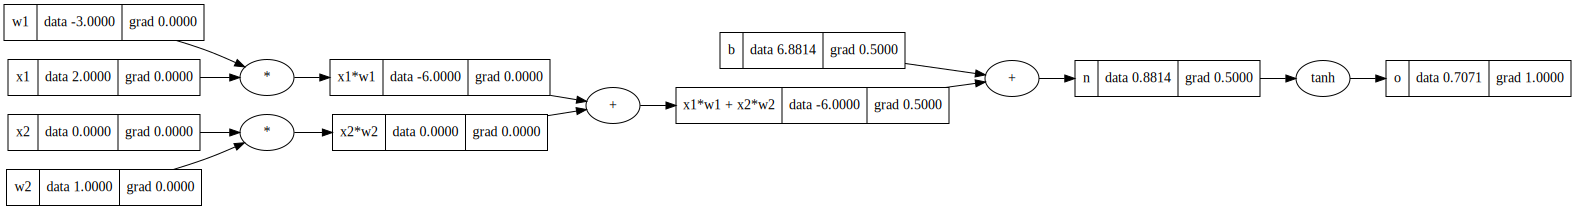

In [16]:
b._backward()
draw_dot(o)

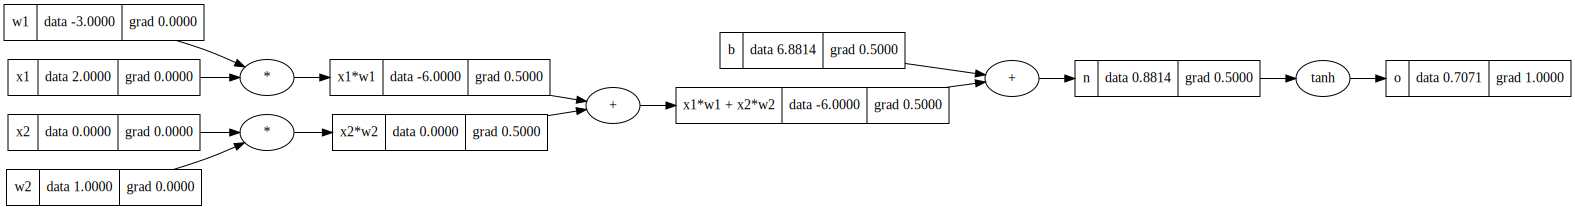

In [17]:
x1w1x2w2._backward()
draw_dot(o)

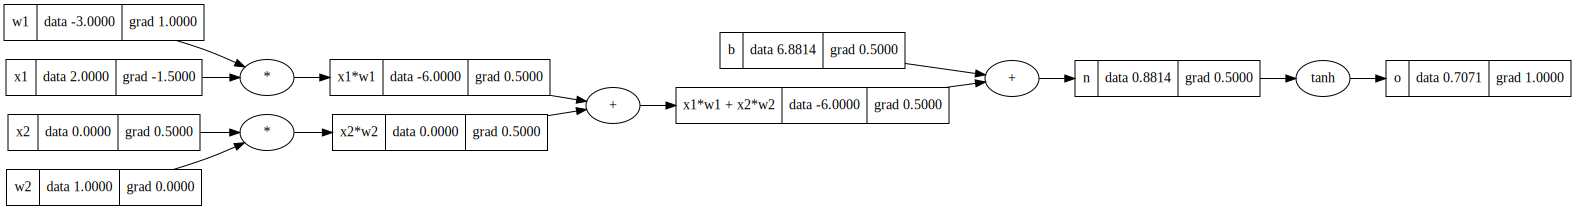

In [18]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

### Same example, but backpropagating using defined function

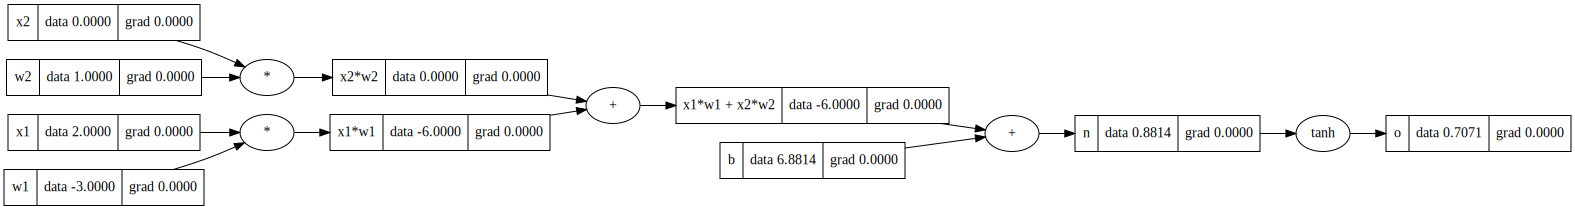

In [27]:
# Resetting the network
# input x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of neuron
b = Value(6.8813735870195432, label = 'b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

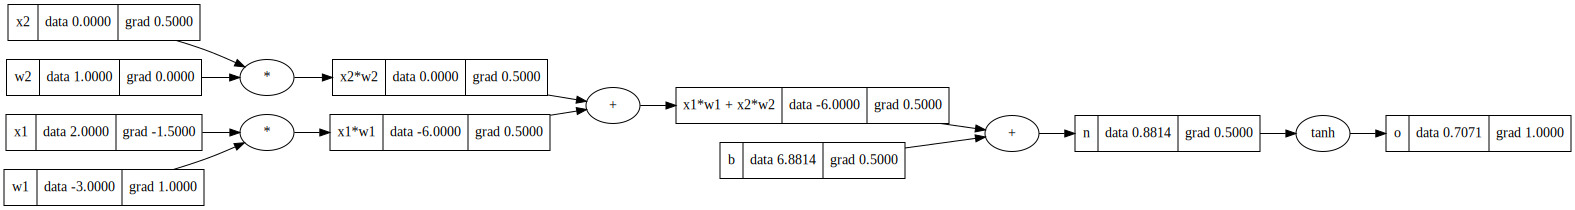

In [28]:
o.backward()
draw_dot(o)

### Implementing tanh using the relation: tanh(x) = (e^(2x) - 1) / ( e^(2x) + 1)

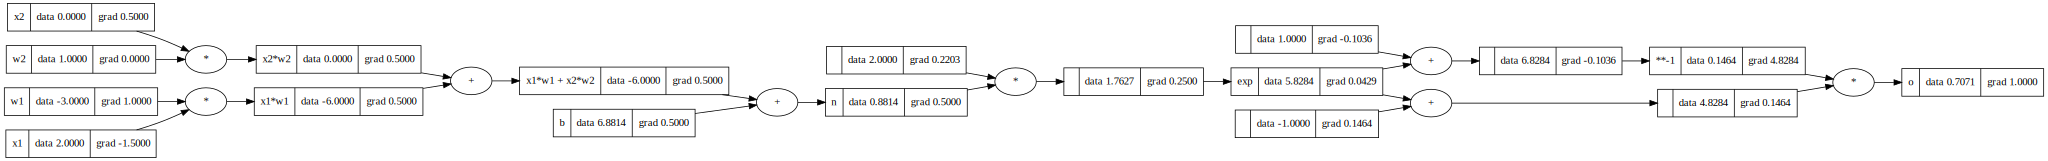

In [51]:
# Resetting the network
# input x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of neuron
b = Value(6.8813735870195432, label = 'b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

#------
e = (2*n).exp()
o = (e-1)/(e+1)

o.label = 'o'
o.backward()
draw_dot(o)

In [54]:
# !pip install torch

                                              0.0/172.3 MB ? eta -:--:--
                                             0.4/172.3 MB 11.2 MB/s eta 0:00:16
                                             1.1/172.3 MB 13.8 MB/s eta 0:00:13
                                             1.8/172.3 MB 14.4 MB/s eta 0:00:12
                                             2.4/172.3 MB 14.1 MB/s eta 0:00:13
                                             3.1/172.3 MB 13.9 MB/s eta 0:00:13
                                             3.7/172.3 MB 13.7 MB/s eta 0:00:13
                                             4.2/172.3 MB 13.5 MB/s eta 0:00:13
     -                                       4.8/172.3 MB 13.2 MB/s eta 0:00:13
     -                                       5.5/172.3 MB 13.5 MB/s eta 0:00:13
     -                                       5.9/172.3 MB 13.5 MB/s eta 0:00:13
     -                                       6.5/172.3 MB 13.0 MB/s eta 0:00:13
     -                                       7.

### Doing same thing in pytorch

In [58]:
import torch

In [61]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; x1.requires_grad = True
b = torch.Tensor([0.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = w1*x1 + w2*x2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print('-------')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())



0.7071066904050358
-------
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


### Defining Multi layer perceptron

In [105]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w*x + b
        activ = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = activ.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
#         params = []
#         for neuron in self.neurons:
#             ps = neuron.parameters()
#             params.extend(ps)
#         return params
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
#         params = []
#         for layer in self.layers:
#             ps = layer.parameters()
#             params.extend(ps)
#         return params
    


In [121]:
x = [3.0, 4.0, 2.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = -0.501839002751207)

In [122]:
n.parameters()

[Value(data = 0.2519455173187355),
 Value(data = 0.8701944799145442),
 Value(data = -0.17540313618831238),
 Value(data = 0.01198568324408833),
 Value(data = -0.48843165914316367),
 Value(data = -0.36745459289765603),
 Value(data = 0.263913514757802),
 Value(data = 0.7901352529957382),
 Value(data = 0.7761779839647964),
 Value(data = -0.929698250045083),
 Value(data = 0.3505760258441737),
 Value(data = 0.8592519667884617),
 Value(data = -0.10956143836513332),
 Value(data = 0.3470602185945959),
 Value(data = -0.9893703063878654),
 Value(data = -0.43262903719873136),
 Value(data = 0.5330124546137962),
 Value(data = 0.8441498852247173),
 Value(data = -0.2912255596410056),
 Value(data = -0.5249163159180248),
 Value(data = -0.5179899796658018),
 Value(data = -0.7141747205238465),
 Value(data = -0.34252478883239923),
 Value(data = -0.2382692735276999),
 Value(data = -0.8991765043522875),
 Value(data = -0.8595119698958291),
 Value(data = 0.17573694134077322),
 Value(data = 0.04204780902695049)

In [123]:
len(n.parameters())

41

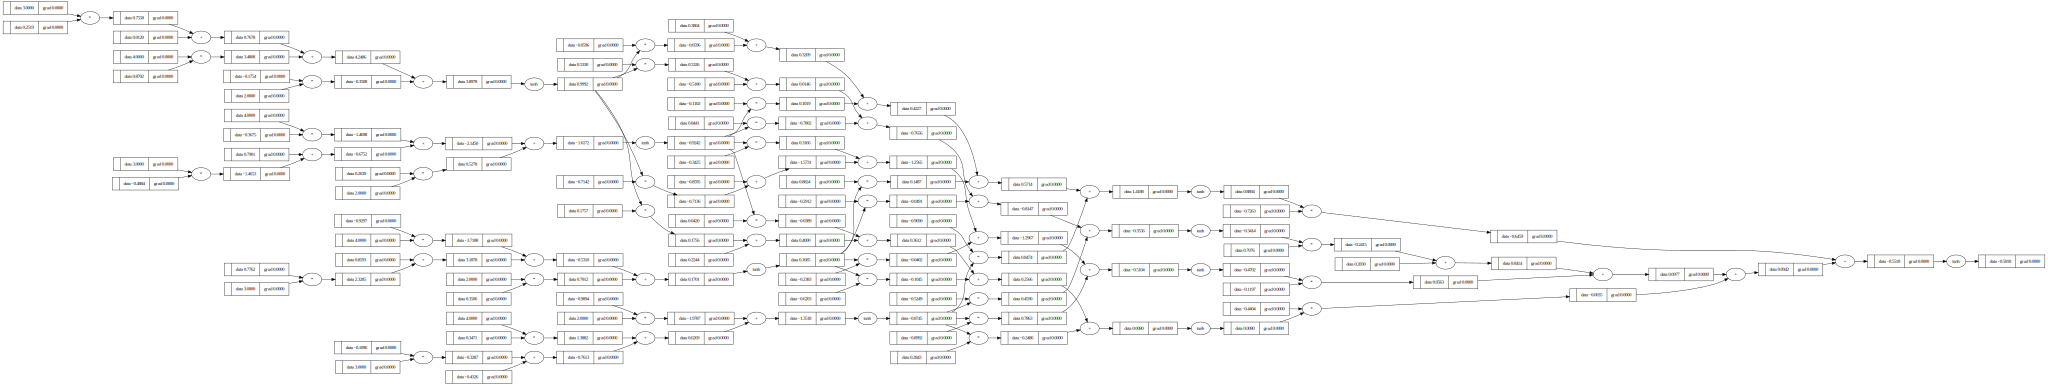

In [124]:
draw_dot(n(x))

### Example

In [125]:
# Example
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data = 0.05924141388641876),
 Value(data = -0.47487435119908095),
 Value(data = 0.09905483673701496),
 Value(data = -0.2181084043657896)]

In [126]:
loss = sum((yout-y)**2 for y, yout in zip(ys, ypred))
loss

Value(data = 3.8524932833166075)

In [133]:
loss.backward()

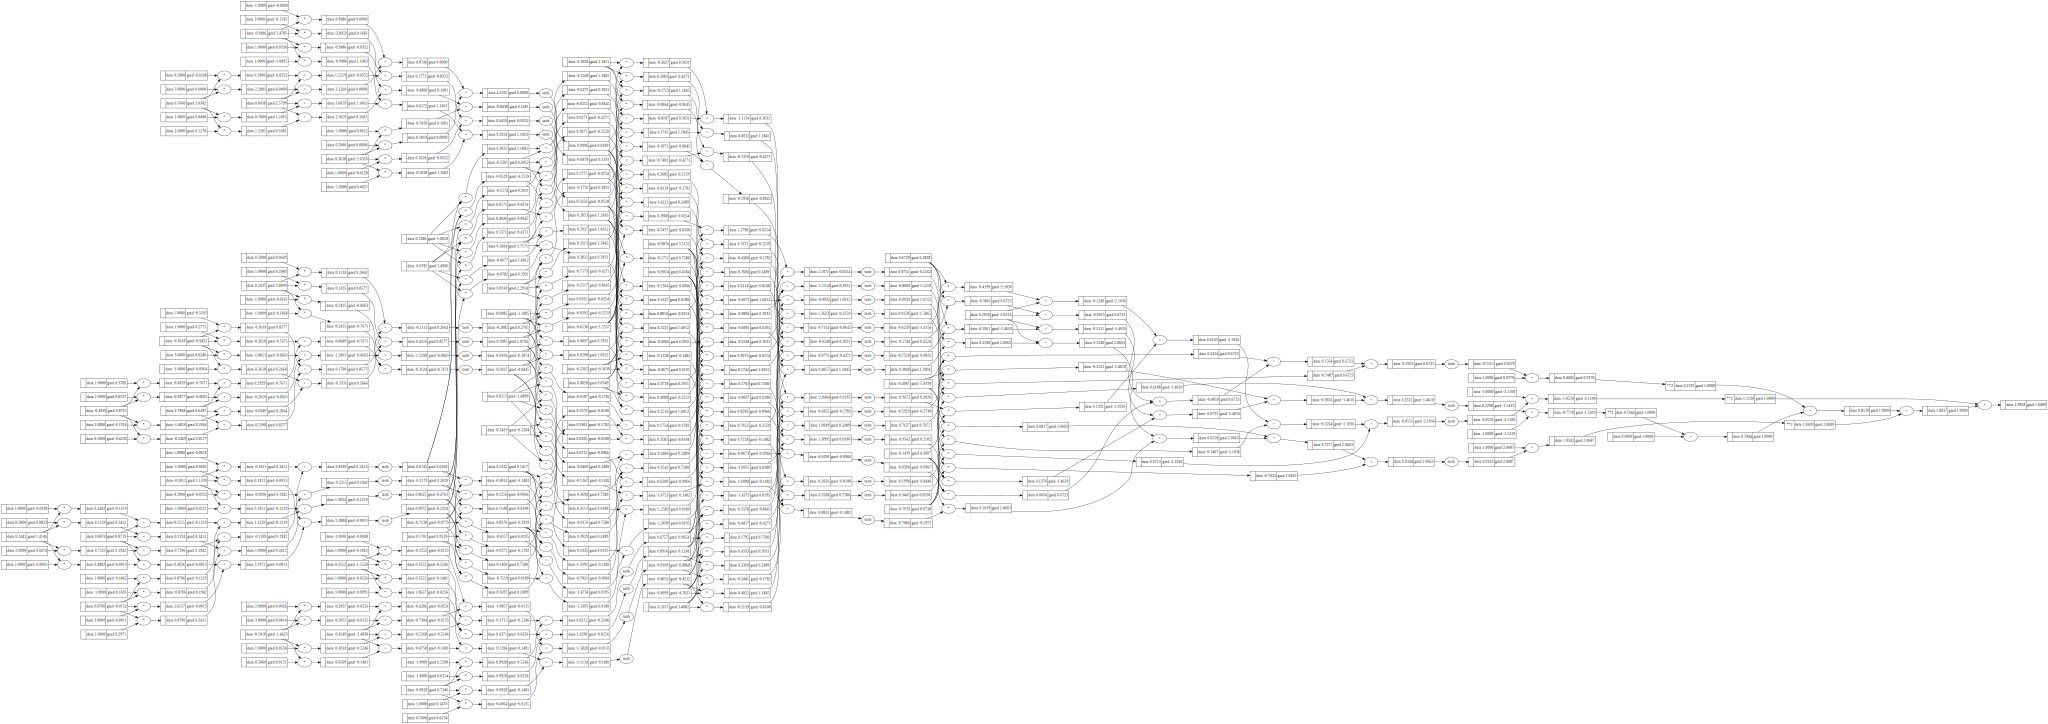

In [134]:
draw_dot(loss)

In [135]:
n.layers[0].neurons[0].w[0].data, n.layers[0].neurons[0].w[0].grad

(0.24408623828454568, 1.414631444538885)

In [136]:
for p in n.parameters():
    p.data += -(0.01 * p.grad)

In [137]:
n.layers[0].neurons[0].w[0].data

0.22993992383915682

In [138]:
ypred = [n(x) for x in xs]
loss = sum((yout-y)**2 for y, yout in zip(ys, ypred))
loss

Value(data = 1.7775599107993951)

In [145]:
x = [3.0, 4.0, 2.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = -0.7640937920397468)

In [146]:
# Example
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

### Updating weights and reducing loss by backpropagation

In [147]:
for k in range(50):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-y)**2 for y, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -(0.01 * p.grad)
    
    print(k, ')', loss.data)
    

0 ) 6.587126285277932
1 ) 6.323513069074403
2 ) 5.972189758862039
3 ) 5.500270057740889
4 ) 4.874904866244798
5 ) 4.092143466148708
6 ) 3.229351330109783
7 ) 2.4514893873898833
8 ) 1.8864190500800881
9 ) 1.5271617250412994
10 ) 1.3013011711346691
11 ) 1.1489775404386555
12 ) 1.0360894892677621
13 ) 0.9452654553524237
14 ) 0.8678539226175728
15 ) 0.7995035135797248
16 ) 0.7379651404095219
17 ) 0.6820176924442349
18 ) 0.6309402502514597
19 ) 0.5842517639805769
20 ) 0.5415837216720678
21 ) 0.5026196937530037
22 ) 0.46706846105218947
23 ) 0.4346536504313697
24 ) 0.4051110585916487
25 ) 0.3781891523073219
26 ) 0.3536505132096148
27 ) 0.3312732023954279
28 ) 0.31085164805199733
29 ) 0.2921969718539298
30 ) 0.2751368119296866
31 ) 0.25951475234498905
32 ) 0.2451894762462278
33 ) 0.23203374673678034
34 ) 0.21993329935502565
35 ) 0.20878570926547174
36 ) 0.19849927790820937
37 ) 0.18899196887880892
38 ) 0.1801904112601786
39 ) 0.17202898009759016
40 ) 0.1644489576532809
41 ) 0.15739777495454899

In [148]:
ypred

[Value(data = 0.8824633023837102),
 Value(data = -0.9808795103502952),
 Value(data = -0.7904062327846532),
 Value(data = 0.7609182685054865)]